In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import display 

import model_utils as utils

# Pretty display for notebooks
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

dataset, features, labels = utils.getDataSet("datasets/dataset.csv.gz")

,AFEC_EDADR,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,ALTO_COSTO,CIE_10,...,PQR_CLASE_SNS,PQR_ESTADO,PQR_TIPOATENCION,PQR_TIPOPETICION,TRIM,AFEC_LOCATION,ENT_LOCATION,PET_LOCATION,COMPLETE_MOTIVE,RIESGO_VIDA
0,0.862194,0.530003,0.865504,0.445166,0.478849,0.304503,1.000000,1.0,0.0,0.086716,...,1.0,0.091348,0.512068,0.658277,0.150914,0.230700,0.280929,0.278713,0.328084,0
1,0.909893,0.530003,1.000000,0.445166,0.478849,0.304503,1.000000,1.0,0.0,0.125322,...,1.0,0.091348,1.000000,0.658277,0.150914,0.221327,0.213105,0.174609,0.209656,0
2,0.862194,0.640631,1.000000,0.445166,0.565950,0.304503,0.661319,1.0,0.0,0.469485,...,1.0,0.091348,1.000000,0.658277,0.150914,0.303620,0.343342,0.307024,0.298898,0
3,0.862194,1.000000,1.000000,0.445166,0.549692,0.304503,0.661319,1.0,0.0,0.023123,...,1.0,0.091348,1.000000,0.658277,0.150914,0.420555,0.531137,0.399282,0.143884,0
4,0.862194,0.530003,1.000000,0.445166,0.549692,0.591697,0.661319,1.0,0.0,0.844386,...,1.0,1.000000,1.000000,0.658277,0.150914,0.287032,0.346242,0.261890,0.361776,1


## Shuffle and Split Data

In [3]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'labels' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size = 0.20, 
                                                    random_state = 10)

# Show the results of the split
print "features_final set has {} samples.".format(features.shape[0])
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

features_final set has 2130783 samples.
Training set has 1704626 samples.
Testing set has 426157 samples.


### Creating a Training and Predicting Pipeline

In [4]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''

tp = float(np.sum(labels['RIESGO_VIDA']))
fp = float(labels['RIESGO_VIDA'].count() - tp)
tn = 0
fn = 0

# TODO: Calculate accuracy, precision and recall
recall = tp / (tp + fn)
precision = tp / (tp + fp)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
# HINT: The formula above can be written as (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
beta = 2
fscore = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

# Print the results 
print "Naive Predictor: [F-score: {:.4f}]".format(fscore)

0.135542192706
Naive Predictor: [Accuracy score: 0.1355, F-score: 0.4395]


/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB trained on 17046 samples.
GaussianNB trained on 170462 samples.
GaussianNB trained on 1704626 samples.


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier trained on 17046 samples.
RandomForestClassifier trained on 170462 samples.
RandomForestClassifier trained on 1704626 samples.
MLPClassifier trained on 17046 samples.
MLPClassifier trained on 170462 samples.
MLPClassifier trained on 1704626 samples.


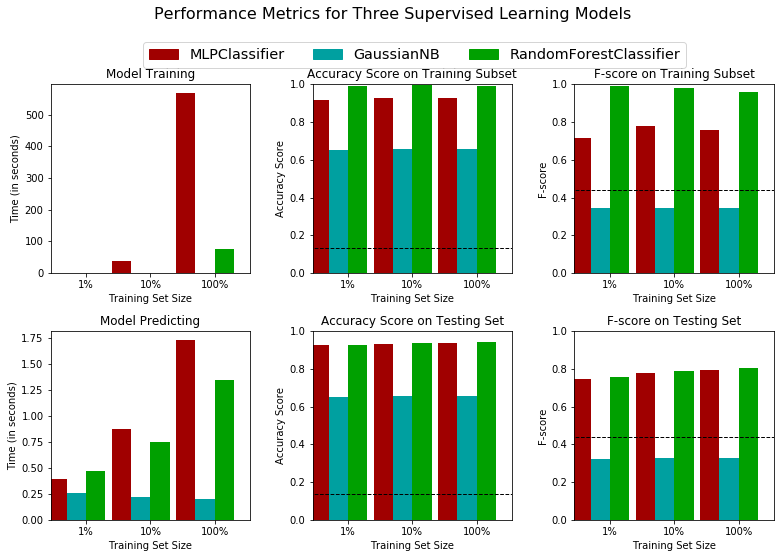

In [19]:
import visuals as vs
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
# Initialize the three models
clf_A = SGDClassifier(random_state = 300)
clf_B = RandomForestClassifier(random_state = 300)
clf_C = SVC(random_state = 300)


samples_100 = len(y_train)
samples_10 = int(samples_100*0.1)
samples_1 = int(samples_10*0.1)

# Collect results on the learners
dfResults = pd.DataFrame(columns=['learner', 'learner_index', 'size_index', 'train_time', 'pred_time', 'f_test', 'f_train'])

for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        dfResults = \
        train_predict(clf, k, i, samples, X_train, y_train, X_test, y_test, dfResults)


In [ ]:
display( dfResults.loc[dfResults['size_index'] == 2].sort_values(by=['f_test'], ascending = False)[['learner', 'f_test']])


# Tuning Models

## Tuning RandomForestClassifier

In [ ]:
from sklearn.externals import joblib

rfClassifier = RandomForestClassifier(random_state = 20)

rfParameters = {    
  'criterion':['gini', 'entropy'],
  'max_depth':[5, 10],
  'max_features':['auto', 'sqrt', 'log2', None],
  'class_weight': ['balanced', 'balanced_subsample'], 
}

rfClassifier = tuneClassifier(rfClassifier, rfParameters)

joblib.dump(rfClassifier, 'rfClassifier.joblib') 

## Tuning SGDClassifier

In [ ]:
sdgClassifier = SGDClassifier(random_state = 20)

sdgParameters = {
  'eta0':[0.01],
  'loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
  'penalty':['none', 'l2', 'l1', 'elasticnet'],
  'learning_rate':['constant', 'optimal', 'invscaling'],
  'class_weight' :['balanced']
  #'max_features':['auto', 'sqrt', 'log2', None],
}

sdgClassifier = tuneClassifier(sdgClassifier, sdgParameters)

joblib.dump(rfClassifier, 'sdgClassifier.joblib') 

# Scaling

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

scalers = [MaxAbsScaler, RobustScaler, QuantileTransformer]


## Scaling for optimized models

In [ ]:
rfScaledClassifier = utils.scaleClassifier(rfClassifier, scalers, features, labels)
sdgScaledClassifier = utils.scaleClassifier(sdgClassifier, scalers, features, labels)
svmScaledClassifier = utils.scaleClassifier(svmClassifier, scalers, features, labels)

# Store Scaled Classifier with higher f beta score
#joblib.dump(xxScaledClassifier, 'xxScaledClassifier.joblib')

